In [84]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=120.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=120.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [85]:
using Printf
using DataFrames
using JLD
using TempModel
using Dates: Date, DateTime
using GaussianProcesses: set_params!
import JSON
using Dates
using PDMats
using LinearAlgebra
using Statistics
using StatsBase: midpoints, Weights
using Distributions
using GaussianProcesses

GPmodel="maternlocal"
ICAO="KBDL"
data_dir="../data"
save_dir="/Volumes/Samsung250GB/saved"
k_nearest=5

5

In [86]:
module Batch
    using ..TempModel
    import PyPlot; plt=PyPlot
    plt.rc("text", usetex=false)
    plt.rc("font", family="serif")
    plt.rc("font", serif="Palatino")
    using LaTeXStrings
    using DataFrames
    using Dates
    using Distributions
    using PDMats
    using LinearAlgebra
    using Printf
    ;
    src_dir = dirname(pathof(TempModel))
    include(joinpath(src_dir, "batch_diagnostics.jl"))
    include(joinpath(src_dir, "plot_diagnostics.jl"))
    include(joinpath(src_dir, "infermean.jl"))
#     include(joinpath(src_dir, "plot_map.jl"))
end

Main.Batch

In [87]:
# load kernel hyperparameters from JSON file
epsg = 3857 # Web Mercator (m)
isdList = TempModel.read_isdList(; data_dir=data_dir, epsg=epsg)
isd_wData = TempModel.stations_with_data(isdList; data_dir=data_dir)

test_station = isd_wData[isd_wData[:ICAO].==ICAO, :]
@assert nrow(test_station) == 1
USAF = test_station[1, :USAF]
WBAN = test_station[1, :WBAN]

isd_nearest_and_test = TempModel.find_nearest(isd_wData, USAF, WBAN, k_nearest)

hourly_cat=TempModel.read_Stations(isd_nearest_and_test; data_dir=data_dir)
itest=1 # first row of isd_nearest_and_test is the test station

1

In [88]:
timezoneGMT = -5 # Georgia
# timezoneGMT = -7 # Arizona
local_time(ts) = ts - Hour(timezoneGMT)
ilocaltime = circshift(1:24, -timezoneGMT)
;

In [89]:
hr_measure = Hour(17)
TnTx = TempModel.test_data(hourly_cat, itest, hr_measure)
hourly_train = hourly_cat[hourly_cat[:station].!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].==itest,:]
hourly_test[:ts_day] = [TempModel.measurement_date(t, hr_measure) for t in hourly_test[:ts]]
# add column to test data for TnTx (useful for plotting)
hourly_test = join(hourly_test, TnTx, on=:ts_day)
;

In [90]:
function plot_pred(GPmodel, test_data, train_data, test_fw, xlim, isdSubset; imputations=1, kwargs...)
    nearby_pred = Batch.get_nearby(test_fw, GPmodel, USAF, WBAN, ICAO, save_dir; 
                                   crossval=true)
    stations_metadata = isdSubset
    Batch.plot_predictive(
            nearby_pred, 
            test_data, train_data, stations_metadata, 
            local_time, 
            xlim; # xlim
            imputations=imputations,
            kwargs...)
    return nearby_pred
end
;

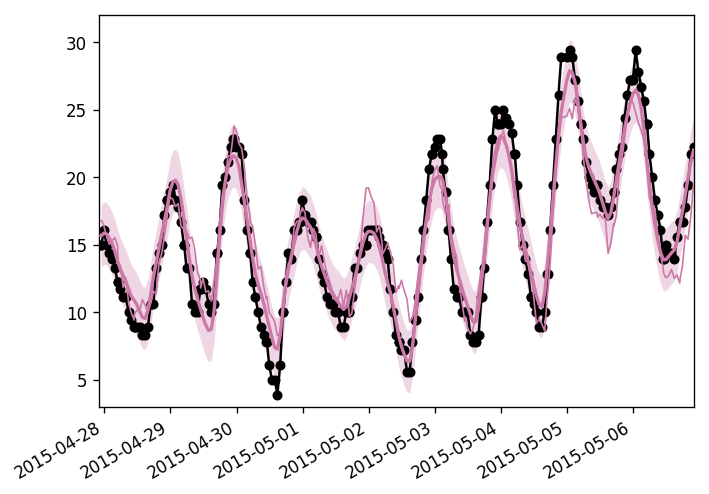

In [91]:
test_fw = Batch.FittingWindow(Date(2015,4,8),Date(2015,6,20))
xlim = (DateTime(2015,4,27,17,0,0), DateTime(2015,5,6,17,0,0))
plot_pred(GPmodel, 
          hourly_test, hourly_train,
          test_fw,
          xlim,
          isd_nearest_and_test;
          subtractmean=false,
          cheat_mean=true,
)
plt.ylim(3,32)
;

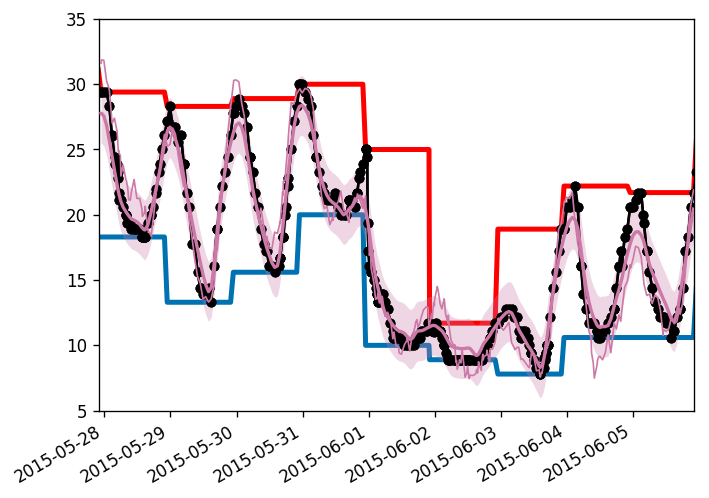

In [92]:
test_fw = Batch.FittingWindow(Date(2015,4,8),Date(2015,6,20))
xlim = (DateTime(2015,5,27,17,0,0), DateTime(2015,6,5,17,0,0))
plot_pred("maternlocal", 
          hourly_test, hourly_train,
          test_fw,
          xlim,
          isd_nearest_and_test;
          subtractmean=false,
          cheat_mean=true,
)
Batch.plot_TnTx(hourly_cat, 1, hr_measure, local_time)
Batch.plot_truth(hourly_test, test_fw, hr_measure, local_time)
plt.ylim(5, 35)
;

In [93]:
let
    stan_fw = Batch.get_window(1, Day(4), Day(12))
    chains, _ts = Batch.get_chains_and_ts(stan_fw, GPmodel, USAF, WBAN, ICAO, save_dir;
                                                crossval=true)
    temp_impute = Batch.get_temperatures_reparam(chains)
    temp_impute = Batch.get_temperatures_reparam(chains)
    Batch.plot_imputations(_ts, temp_impute, local_time; plot_mean=false, impt_indices=[250,500])
end

SystemError: SystemError: unable to read directory /Volumes/Samsung250GB/saved/stan_fit/crossval/maternlocal/KBDL/725080_14740_KBDL_2014-12-31_to_2015-01-12/: No such file or directory

In [94]:
daily_imputed_means_fname = "/Volumes/Samsung250GB/saved/daily_mean/crossval/$(GPmodel)/daily_means_$(ICAO).json"
open(daily_imputed_means_fname, "r") do io
    global all_posteriors = JSON.parse(io)
end

days_vec, day_means, day_cov, day_buffer, buffer_cov = Batch.daily_best(all_posteriors);

In [95]:
function true_mean_day(hourly, hr_measure)
    ts, temp = hourly[:ts], hourly[:temp]
    temp_mid = midpoints(temp)
    ts_mid, ts_diff = midpoints(ts), diff(ts)
    ts_mid_day = TempModel.measurement_date.(ts_mid, hr_measure)
    days = sort(unique(ts_mid_day))[1:end]
    ndays = length(days)
    means_by_day = Float64[]
    total_duration = Float64[]
    for iday in 1:ndays
        day = days[iday]
        sub = ts_mid_day .== day
        ts_sub, diff_sub = ts_mid[sub], ts_diff[sub]
        weights = Weights(diff_sub ./ Millisecond(1))
        temp_sub = temp_mid[sub]
        mean_temp = mean(temp_sub, weights)
        push!(means_by_day, mean_temp)
        push!(total_duration, sum(diff_sub) ./ convert(Millisecond, Hour(1)))
    end
    return days, means_by_day, total_duration
end
;

In [96]:
true_days, true_means_by_day, total_duration = true_mean_day(hourly_test, hr_measure)
;
# sanity check
mintime,maxtime = extrema(hourly_test[:ts])
hourlytest_range = (maxtime-mintime) / convert(Millisecond, Hour(1))
@assert hourlytest_range ≈ sum(total_duration)

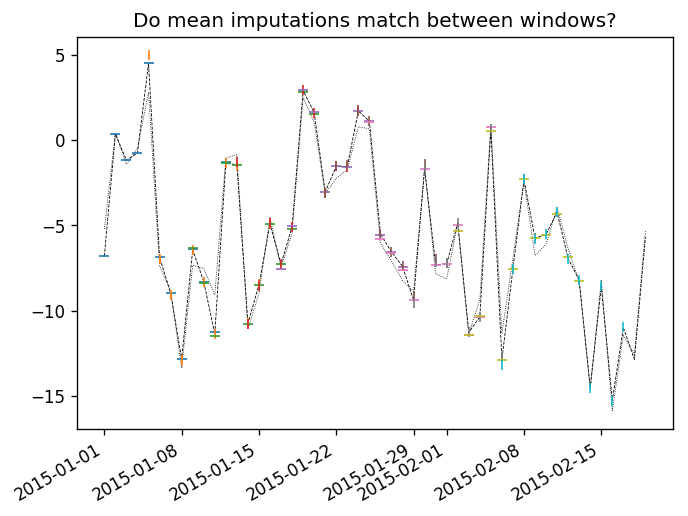

In [97]:
for iday in 1:10
    x = all_posteriors[iday]["days"]
    y = all_posteriors[iday]["mean"]
    if iday%2==0
        marker = "|"
    else
        marker = "_"
    end
    plt.plot(x,y, marker, alpha=1.0)
end
plt.plot(days_vec[1:50], day_means[1:50], "--", color="black", linewidth=0.5, zorder=-1)
plt.plot(true_days[1:50], true_means_by_day[1:50], ":", color="black", linewidth=0.5, zorder=0)
plt.title("Do mean imputations match between windows?")
plt.gcf()[:autofmt_xdate]()
;

In [98]:
posterior_mean = mean(day_means)
true_mean = mean(true_means_by_day[1:length(day_means)])
posterior_std = sqrt(sum(day_cov) / length(day_means)^2)
(posterior_mean - true_mean) / posterior_std

2.930390002626145

In [134]:
@show posterior_mean
@show true_mean
@show posterior_std

posterior_mean = 10.921095163615608
true_mean = 10.780595384393662
posterior_std = 0.04794576117719254


0.04794576117719254

In [99]:
# Taking into account the covariance increases the posterior variance,
# which is a good thing.
sum(day_cov), tr(day_cov)

(307.9375189666375, 88.6919272228313)

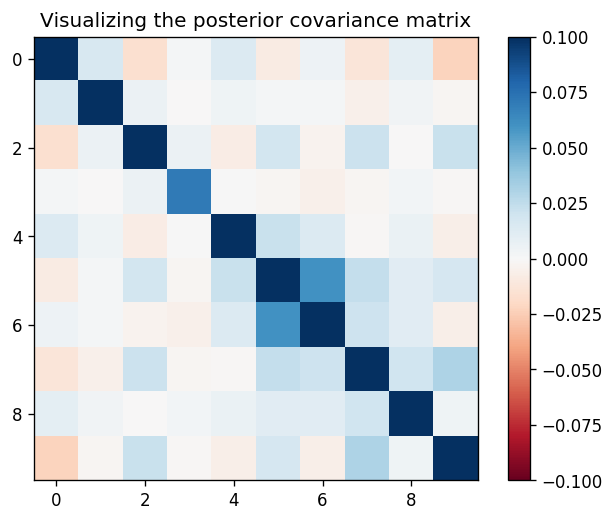

In [100]:
plt.imshow(day_cov[1:10,1:10], vmin=-0.1, vmax=0.1, cmap="RdBu")
plt.colorbar()
plt.title("Visualizing the posterior covariance matrix")
;

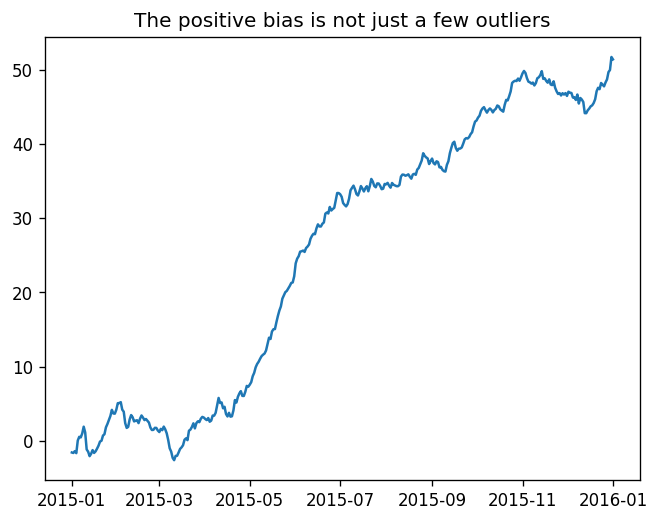

In [101]:
plt.title("The positive bias is not just a few outliers")
plt.plot(days_vec, cumsum(day_means .- true_means_by_day[1:length(day_means)]))
;

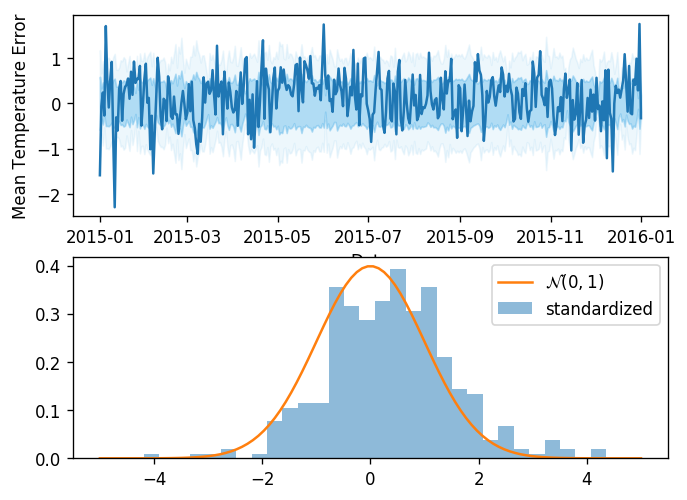

In [132]:
x = days_vec
err = day_means .- true_means_by_day[1:length(day_means)]
SE = sqrt.(diag(day_cov))
plt.subplot(2,1,1)
plt.plot(x, err)
plt.fill_between(x, -SE, +SE, alpha=0.4, color=cbbPalette[2])
plt.fill_between(x, -2SE, +2SE, alpha=0.1, color=cbbPalette[2])
plt.ylabel("Mean Temperature Error")
plt.xlabel("Date")
plt.subplot(2,1,2)
day_cov_PD = PDMat(Symmetric(day_cov+1e-1I)) # positive definite matrix of the covariances between 
standardized_error = err ./ SE
# whitened_error = whiten(day_cov_PD, err)
# plt.plt[:hist](whitened_error, bins=30, normed=true, alpha=0.5, label="whitened")
plt.plt[:hist](standardized_error, bins=30, normed=true, alpha=0.5, label="standardized")
xx = range(-5, stop=5, length=100)
plt.plot(xx, pdf.(Normal(), xx), label=L"\mathcal{N}(0,1)")
plt.legend(loc="auto")
;

## worst days

In [103]:
mean(err), mean(whitened_error), mean(standardized_error)

(0.14049977922194476, 0.39192744619420944, 0.4817711483458355)

No matter wheter we just whiten or standardize, we observe the positive bias in errors. Now let's find the worst day:

In [104]:
days_vec[argmax(standardized_error)], maximum(standardized_error)

(2015-04-09, 4.127159876445983)

In [105]:
days_vec[argmax(err)], maximum(err), sqrt(day_cov[argmax(err),argmax(err)])

(2015-12-31, 1.7529472997267197, 0.5571273976221778)

In [106]:
standardized_error[argmax(err)]

2.5139023074549662

## examine imputations

In [107]:
# distances
isd_nearest_and_test[:distance] = sqrt.(
(isd_nearest_and_test[:X_PRJ] .- isd_nearest_and_test[1,:X_PRJ]).^2 .+
(isd_nearest_and_test[:Y_PRJ] .- isd_nearest_and_test[1,:Y_PRJ]).^2) ./ 1e3
isd_nearest_and_test[:,[:ICAO,:distance]]

,ICAO,distance
,String⍰,Float64
1,KBDL,0.0
2,KCEF,42.6902
3,KBDR,126.199
4,KPVD,142.842
5,KSWF,170.731
6,KALB,174.386


Note that KCEF is by far the nearest station!

In [108]:
Batch.get_window(37, Day(4), Day(12))

Main.Batch.FittingWindow(2015-05-25, 2015-06-06)

In [109]:
plt.title("Examining the day of maximum STANDARDIZED error")
plt.axvline(days_vec[argmax(standardized_error)], zorder=-10, linewidth=1, color="grey")
let
    stan_fw = Batch.get_window(111, Day(4), Day(12))
    local chains, _ts = Batch.get_chains_and_ts(stan_fw, GPmodel, USAF, WBAN, ICAO, save_dir)
        temp_impute = Batch.get_temperatures_reparam(chains)
    temp_impute = Batch.get_temperatures_reparam(chains)
    Batch.plot_imputations(_ts, temp_impute, local_time; plot_mean=false, impt_indices=[250,500])
end
plt.gcf()[:autofmt_xdate]()
plt.xlim(Date(2015,12,1), Date(2015,12,4))
plt.ylim(0,7)
_xlim = plt.xlim()
_ylim = plt.ylim()
Batch.plot_neighbours(hourly_train, 
                      isd_nearest_and_test,
                      local_time,
                      (DateTime(2015,11,15), DateTime(2015,12,15));
                      subtractmean=false,
                      color="black",
                      linewidth=1,
                      markersize=3,
                      alpha=0.4,
                      zorder=10)
fw = Batch.FittingWindow(DateTime(2015,11,27,0,0,0), DateTime(2015,12,6,0,0,0))
Batch.plot_truth(hourly_test, fw, hr_measure, local_time)
Batch.plot_TnTx(hourly_cat, 1, hr_measure, local_time)
plt.xlim(_xlim)
plt.ylim(_ylim)
plt.legend(loc="auto")
;

UndefKeywordError: UndefKeywordError: keyword argument crossval not assigned

In [110]:
plt.title("Examining the day of maximum ABSOLUTE error")
plt.axvline(days_vec[argmax(err)], zorder=-10, linewidth=1, color="grey")
let
    stan_fw = Batch.get_window(50)
    local chains, _ts = Batch.get_chains_and_ts(stan_fw, GPmodel, USAF, WBAN, ICAO, save_dir)
        temp_impute = Batch.get_temperatures_reparam(chains)
    temp_impute = Batch.get_temperatures_reparam(chains)
    Batch.plot_imputations(_ts, temp_impute, local_time; plot_mean=false, impt_indices=[250,500])
end
plt.gcf()[:autofmt_xdate]()
_xlim = plt.xlim()
_ylim = plt.ylim()
fw = Batch.FittingWindow(DateTime(2015,5,15), DateTime(2015,6,15))
Batch.plot_truth(hourly_test, fw, hr_measure, local_time)
Batch.plot_TnTx(hourly_cat, 1, hr_measure, local_time)
plt.xlim(_xlim)
plt.ylim(_ylim)
;

MethodError: MethodError: no method matching get_window(::Int64)
Closest candidates are:
  get_window(::Int64, !Matched::Day, !Matched::Day) at /Users/imolk/Documents/Harvard/Natesh/TempModel/src/batch_diagnostics.jl:133

June 1st is a +3.9σ error: that's pretty bad.

Note the next day (June 2) has a very similar pattern to December 2nd: the true time series stays at the minimum for a long time, but the imputations don't follow, resulting in a +4σ error in both cases.

The plot below is the same thing zoomed in, with neighboring observations added:

In [111]:
plt.title("Examining the day of maximum ABSOLUTE error")
plt.axvline(days_vec[argmax(err)], zorder=-10, linewidth=1, color="grey")
let
    stan_fw = Batch.get_window(50)
    local chains, _ts = Batch.get_chains_and_ts(stan_fw, GPmodel, USAF, WBAN, ICAO, save_dir)
        temp_impute = Batch.get_temperatures_reparam(chains)
    temp_impute = Batch.get_temperatures_reparam(chains)
    Batch.plot_imputations(_ts, temp_impute, local_time; plot_mean=false, impt_indices=[250,500])
end
plt.gcf()[:autofmt_xdate]()
plt.xlim(DateTime(2015,5,31), DateTime(2015,6,3))
_xlim = plt.xlim()
_ylim = plt.ylim()
Batch.plot_neighbours(hourly_train, 
                      isd_nearest_and_test,
                      local_time,
                      (DateTime(2015,5,25), DateTime(2015,6,15));
                      subtractmean=false,
                      linewidth=1,
                      markersize=3,
                      alpha=0.4,
                      zorder=10)
fw = Batch.FittingWindow(DateTime(2015,5,15), DateTime(2015,6,15))
Batch.plot_truth(hourly_test, fw, hr_measure, local_time)
Batch.plot_TnTx(hourly_cat, 1, hr_measure, local_time)
plt.xlim(_xlim)
plt.ylim(_ylim)
plt.legend(loc="auto", fontsize="small")
;

MethodError: MethodError: no method matching get_window(::Int64)
Closest candidates are:
  get_window(::Int64, !Matched::Day, !Matched::Day) at /Users/imolk/Documents/Harvard/Natesh/TempModel/src/batch_diagnostics.jl:133

Again, KCEF, which is very near, provides a very good guide to the temperatures at KBDL, but the imputations don't follow it, instead preferring to stay higher.
Some things to think about and explore:
- because the window is short and the mean has a wide prior, the model can shift the imputations up by a constant at very little cost
- it then just has to dip down to avoid crossing the $T_n$ line. We see this possibly happening on both days in the above plot (imputations dip at the last second before the next day starts).
- But why do the want to be higher? This may be to avoid the cost of the smoothmin/min difference (see below).

## closer look at December 2nd

In [112]:
smoothmax(x, k, maxkx) = (maxkx + log(sum(xi ->exp(k*xi - maxkx), x)))/k
smoothmin(x, k, minkx) = (minkx - log(sum(xi ->exp(-k*xi + minkx), x)))/k
december2 = hourly_test[hourly_test[:ts_day] .== Date(2015,12,2), :]
maxtemp = maximum(december2[:temp])

5.0

In [113]:
mean(december2[:temp])

3.375510204081634

In [114]:
k = 20.0
smoothmax(december2[:temp], k, k*maxtemp), maxtemp

(5.000001229028056, 5.0)

In [115]:
k = 20.0
smoothmin(december2[:temp], k, k*mintemp), mintemp

UndefVarError: UndefVarError: mintemp not defined

Large difference between smoothmin and min!
We need a very large $k$ to avoid this and stay within $\epsilon=0.01$ of the true minimum.
Is this causing trouble?

In [116]:
kk = range(10.0, stop=300.0, length=100)
plt.plot(kk, smoothmin.(Ref(december2[:temp]), kk, kk.*mintemp))
plt.axhline(mintemp, color="red")
plt.fill_between(kk, 
        fill(mintemp-0.01, length(kk)), fill(mintemp, length(kk)), 
        color="red", alpha=0.1)
;

UndefVarError: UndefVarError: mintemp not defined

In [117]:
k = 20.
x = [1., 10.]
smoothmax(x, k, k*maximum(x))
x = [9.99, 10.]
smoothmax(x, k, k*maximum(x))

10.02990694346908

In [118]:
stan_fw = Batch.get_window(111)
chains, _ts = Batch.get_chains_and_ts(stan_fw, GPmodel, USAF, WBAN, ICAO, save_dir)
    temp_impute = Batch.get_temperatures_reparam(chains)
temp_impute = Batch.get_temperatures_reparam(chains)
@show size(temp_impute)

impute_december2 = temp_impute[
    :, # samples
    [t ∈ december2[:ts] for t in _ts], # time
    :]
;

MethodError: MethodError: no method matching get_window(::Int64)
Closest candidates are:
  get_window(::Int64, !Matched::Day, !Matched::Day) at /Users/imolk/Documents/Harvard/Natesh/TempModel/src/batch_diagnostics.jl:133

In [119]:
k = 20.0
imputedsm = Float64[] # collection of imputed smooth maximum
imputedmax = Float64[]
imputedargmax = Int[]
imputedmean = Float64[]
for isample in 1:size(impute_december2,1)
    for ichain in 1:4
        temp = impute_december2[isample,:,ichain]
        sm = smoothmax(temp, k, k*maxtemp)
        push!(imputedmax, maximum(temp))
        push!(imputedargmax, argmax(temp))
        push!(imputedsm, sm)
        push!(imputedmean, mean(temp))
    end
end

UndefVarError: UndefVarError: impute_december2 not defined

In [120]:
mean(imputedmean), std(imputedmean)

(NaN, NaN)

In [121]:
(mean(imputedmean)-mean(december2[:temp])) / std(imputedmean)

NaN

In [122]:
plt.step(1:maximum(imputedargmax), StatsBase.counts(imputedargmax))

ArgumentError: ArgumentError: reducing over an empty collection is not allowed

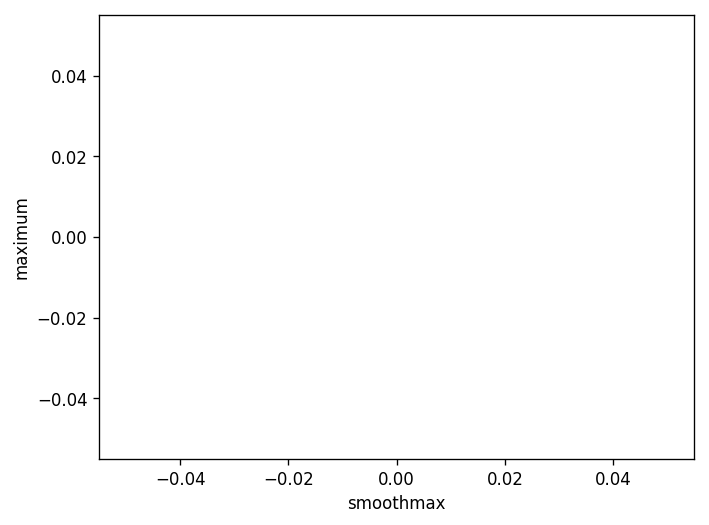

In [123]:
plt.plot(imputedsm, imputedmax, "x", alpha=0.1)
_xlim, _ylim = plt.xlim(), plt.ylim()
plt.plot([4,6], [4,6], color="black")
plt.xlim(_xlim), plt.ylim(_ylim)
plt.xlabel("smoothmax")
plt.ylabel("maximum")
;

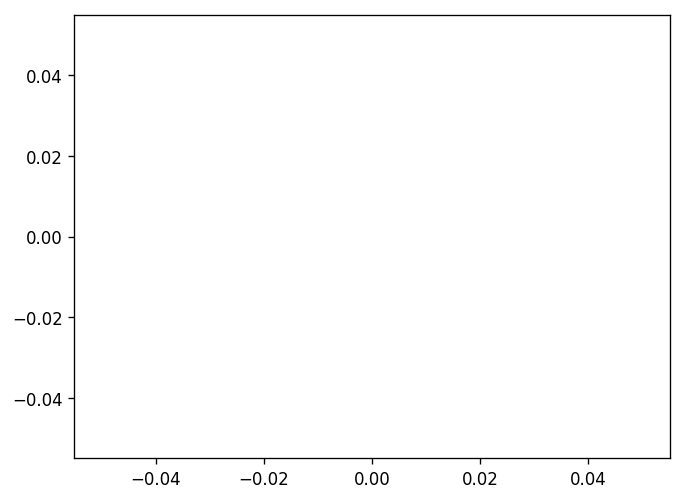

In [124]:
epsilon = 0.01
plt.plt[:hist]((imputedsm .- maxtemp), bins=20, normed=true, alpha=0.5)
plt.plt[:hist]((imputedmax .- maxtemp), bins=20, normed=true, alpha=0.5)
xx = range(-3, stop=3, length=100)
;